# TP2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install keras-tuner --upgrade
!pip install keras==2.12.0
import pandas as pd
import numpy as np
#librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score,accuracy_score,f1_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import time
import datetime

np.random.seed(99)
tf.random.set_seed(99)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


## Enunciado
Los conjuntos de datos a utilizar train y test se encuentran disponibles en la competencia de
Kaggle y deberán descargarlos desde allí. Allí mismo encontrarán también un archivo de
ejemplo de cómo se deben subir las soluciones.
El trabajo consiste en construir diferentes modelos de clasificación, capaces de analizar una
porción de texto en lenguaje natural y detectar el sentimiento allí presente, al menos de forma
binaria: positivo o negativo.
Para ello habrá que realizar un preprocesamiento del texto para que este pueda ser analizado
por los distintos modelos. Se utilizará el modelo de bag of words, o cualquier otro que permita
convertir texto en vectores.

Los modelos que se deben construir son los siguientes:

* Bayes Naïve
* Random Forest
* XGBoost
* Un modelo de red neuronal aplicando Keras y Tensor Flow.
* Un ensamble de al menos 3 modelos elegidos por el grupo.

Para cada uno de estos modelos se debe realizar una búsqueda de hiperparametros que
optimicen su desempeño en el conjunto de test local (porción del archivo training).
Una vez encontrados dichos hiperparametros, se procederá a hacer un submit a Kaggle. Es decir
que habrá al menos 5 submits (uno por cada modelo).

## Importamos librerías y datasets:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

from scipy.stats import uniform, randint

import xgboost as xgb
from xgboost import XGBClassifier

from joblib import dump, load

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Montamos Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ds_train = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/train.csv')
ds_test = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/test.csv')
ds_train_stemmed = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/datasets/train_con_stemming_aplicado.csv')

## Análisis de datos

Realizamos una primera lectura de los dataset:

In [ ]:
ds_train

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


In [ ]:
ds_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [ ]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


No tenemos datos nulos

In [ ]:
ds_train['sentimiento'].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Tenemos la misma cantidad de reseñas positivas y negativas

### Aplicamos stemming a la columna de review_es

In [ ]:
ds_train_copy = ds_train.copy()
ds_train_copy['review_es'][0]

'Uno de los otros críticos ha mencionado que después de ver solo 1 Oz Episodio, estará enganchado. Tienen razón, ya que esto es exactamente lo que sucedió conmigo. La primera cosa que me golpeó sobre Oz fue su brutalidad y sus escenas de violencia inconfiadas, que se encuentran a la derecha de la palabra. Confía en mí, este no es un espectáculo para los débiles de corazón o tímido. Este espectáculo no extrae punzones con respecto a las drogas, el sexo o la violencia. Es Hardcore, en el uso clásico de la palabra. Se llama OZ, ya que es el apodo dado al Penitenciario del Estado de Seguridad Máximo de Oswald. Se centra principalmente en la ciudad de Emeralda, una sección experimental de la prisión donde todas las células tienen frentes de vidrio y se enfrentan hacia adentro, por lo que la privacidad no es alta en la agenda. Em City es el hogar de muchos ... Fariarios, musulmanes, gangstas, latinos, cristianos, italianos, irlandeses y más ... así que las esposas, las miradas de muerte, las

In [ ]:
from nltk.stem import SnowballStemmer
from nltk import word_tokenize

# Descarga de recursos necesarios para NLTK (esto se hace una vez)
nltk.download('punkt')
nltk.download('stopwords')

# Configura el stemmer para español
stemmer = SnowballStemmer("spanish")

# Ejemplo de función para aplicar stemming a una fila de la columna 'ds_train_x'
def apply_stemming(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)



# Aplica la función a la columna 'ds_train_x'
ds_train_x_stemmed = ds_train_copy['review_es'].apply(apply_stemming)
ds_train_x_stemmed[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'uno de los otros critic ha mencion que despues de ver sol 1 oz episodi , estar enganch . tien razon , ya que esto es exact lo que suced conmig . la primer cos que me golpe sobr oz fue su brutal y sus escen de violenci inconfi , que se encuentr a la derech de la palabr . conf en mi , este no es un espectacul par los debil de corazon o tim . este espectacul no extra punzon con respect a las drog , el sex o la violenci . es hardcor , en el uso clasic de la palabr . se llam oz , ya que es el apod dad al penitenciari del estad de segur maxim de oswald . se centr principal en la ciud de emerald , una seccion experimental de la prision dond tod las celul tien frent de vidri y se enfrent haci adentr , por lo que la privac no es alta en la agend . em city es el hog de much ... fariari , musulman , gangst , latin , cristian , italian , irlandes y mas ... asi que las espos , las mir de muert , las relacion peligr y los acuerd sombr nunc estan lej . yo dir el principal atract de el espectacul se 

In [ ]:
ds_train_copy['review_es'] = ds_train_x_stemmed
ds_train_copy.head()

,ID,review_es,sentimiento
0,0,uno de los otros critic ha mencion que despues...,positivo
1,1,una pequeñ pequeñ produccion.l tecnic de filma...,positivo
2,2,pens que esta era una maner maravill de pas ti...,positivo
3,3,"basic , hay una famili dond un niñ pequeñ ( ja...",negativo
4,4,el `` amor en el tiemp '' de pett mattei es un...,positivo


In [ ]:
ds_train_copy.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/datasets/train_con_stemming_aplicado.csv')

## Realizamos una division de train para pruebas

In [ ]:
#Division del dataset
ds_train_x = ds_train['review_es']
ds_train_y = ds_train['sentimiento']

### Aplicamos el train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds_train_x,
                                                    ds_train_y,
                                                    test_size=0.30,
                                                    random_state = 99)

## Bayes Naïve

### Creamos un primer modelo con CountVectorizer()

A continuación creamos un modelo básico preprocesando con CountVectorizer (Utilizando los hiperparámetros por defecto)

In [ ]:
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.83      0.88      0.85      7489
    positivo       0.87      0.81      0.84      7511

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'Valores reales')

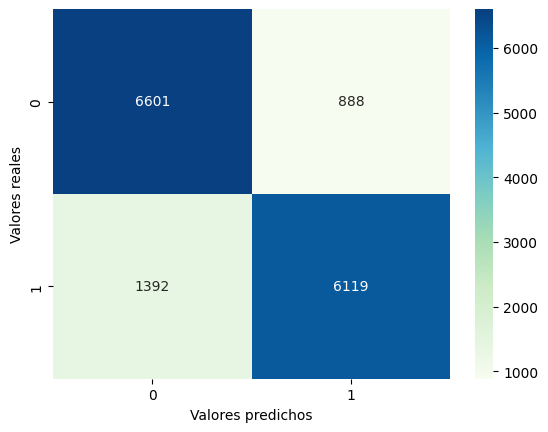

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Creamos otro modelo, esta vez con TfidfVectorizer()

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.85      0.88      0.86      7489
    positivo       0.87      0.85      0.86      7511

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Observamos una leve mejoría respecto a CountVectorizer tanto en accuracy como en el balance de negativas/positivas correctamente predichas.

Text(50.722222222222214, 0.5, 'Valores reales')

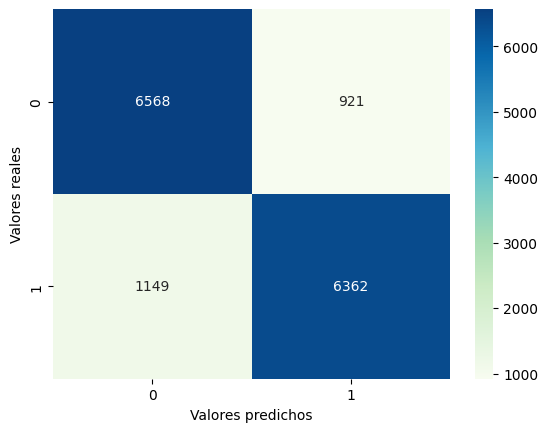

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### También probamos con HashingVectorizer

In [ ]:
model = make_pipeline(HashingVectorizer(alternate_sign=False), MultinomialNB())
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.81      0.91      0.86      7489
    positivo       0.89      0.79      0.84      7511

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Con HashingVectorizer obtuvimos una precisión de predicción mas alta que TfidfVectorizer para reseñas positivas, pero esto llega a un pequeño desbalance entre clases. Por lo tanto, decidimos que para el preprocesamiento utilizaremos TfidfVectorizer.

Text(50.722222222222214, 0.5, 'Valores reales')

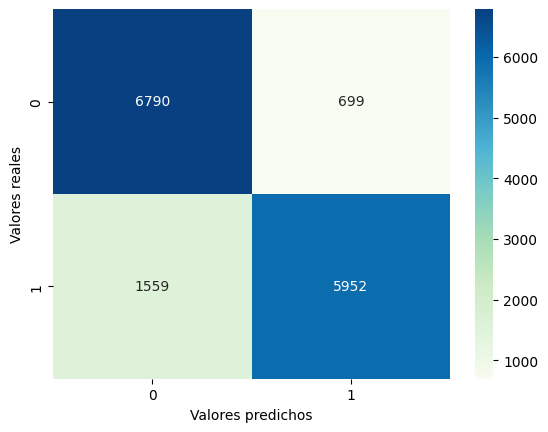

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

Realizamos una predicción del dataset test

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(ds_train_x, ds_train_y)
y_pred = model.predict(ds_test['review_es'])

In [ ]:
y_pred

array(['negativo', 'negativo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype='<U8')

In [ ]:
submission_modelo_basico = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred})
submission_modelo_basico.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_modelo_basico.csv', index=False)

In [ ]:
submission_modelo_basico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Guardamos el modelo

In [ ]:
dump(model, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_basico.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_basico.joblib']

### Optimizamos hiperparámetros


Buscamos los mejores hiperparámetros tanto para TfidfVectorizer como para Bayes Naive con RandomizedSearchCV

#### Utilizando TfidfVectorizer

In [ ]:
clasificador = make_pipeline(TfidfVectorizer(), MultinomialNB())


param_dist = {
    'multinomialnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'multinomialnb__fit_prior': [True, False],
    'tfidfvectorizer__strip_accents': ['ascii', None],
    'tfidfvectorizer__lowercase': [True, False]
}


random_search = RandomizedSearchCV(clasificador,
                                   scoring='f1_micro',
                                   param_distributions=param_dist,
                                   n_iter=15,
                                   cv=4,
                                   n_jobs=1,
                                   random_state=99,
                                   verbose=4)


random_search.fit(ds_train_x, ds_train_y)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("F1-score con mejores hiperparámetros:", random_search.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END multinomialnb__alpha=1.5, multinomialnb__fit_prior=True, tfidfvectorizer__lowercase=True, tfidfvectorizer__strip_accents=None;, score=0.855 total time=  11.4s
[CV 2/4] END multinomialnb__alpha=1.5, multinomialnb__fit_prior=True, tfidfvectorizer__lowercase=True, tfidfvectorizer__strip_accents=None;, score=0.852 total time=  12.4s
[CV 3/4] END multinomialnb__alpha=1.5, multinomialnb__fit_prior=True, tfidfvectorizer__lowercase=True, tfidfvectorizer__strip_accents=None;, score=0.855 total time=  13.4s
[CV 4/4] END multinomialnb__alpha=1.5, multinomialnb__fit_prior=True, tfidfvectorizer__lowercase=True, tfidfvectorizer__strip_accents=None;, score=0.854 total time=  12.9s
[CV 1/4] END multinomialnb__alpha=2.0, multinomialnb__fit_prior=False, tfidfvectorizer__lowercase=True, tfidfvectorizer__strip_accents=ascii;, score=0.854 total time=  13.5s
[CV 2/4] END multinomialnb__alpha=2.0, multinomialnb__fit_prior=False, tfidfv

In [ ]:
best_estimator = random_search.best_estimator_

In [ ]:
best_estimator.fit(ds_train_x, ds_train_y)
y_pred_optimizado = best_estimator.predict(ds_test['review_es'])

#### Utilizando HashingVectorizer

In [ ]:
clasificador = make_pipeline(HashingVectorizer(alternate_sign=False), MultinomialNB())


param_dist = {
    'multinomialnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'multinomialnb__fit_prior': [True, False],
    'hashingvectorizer__strip_accents': ['ascii', None],
    'hashingvectorizer__lowercase': [True, False]
}


random_search = RandomizedSearchCV(clasificador,
                                   scoring='f1_micro',
                                   param_distributions=param_dist,
                                   n_iter=15,
                                   cv=4,
                                   n_jobs=1,
                                   random_state=99,
                                   verbose=4)


random_search.fit(ds_train_x, ds_train_y)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("F1-score con mejores hiperparámetros:", random_search.best_score_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV 1/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=ascii, multinomialnb__alpha=1.0, multinomialnb__fit_prior=False;, score=0.843 total time=  10.9s
[CV 2/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=ascii, multinomialnb__alpha=1.0, multinomialnb__fit_prior=False;, score=0.835 total time=   8.8s
[CV 3/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=ascii, multinomialnb__alpha=1.0, multinomialnb__fit_prior=False;, score=0.844 total time=  11.1s
[CV 4/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=ascii, multinomialnb__alpha=1.0, multinomialnb__fit_prior=False;, score=0.841 total time=  11.0s
[CV 1/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=None, multinomialnb__alpha=1.5, multinomialnb__fit_prior=True;, score=0.839 total time=   9.4s
[CV 2/4] END hashingvectorizer__lowercase=Fals

In [ ]:
y_pred = random_search.predict(ds_test['review_es'])

submission_modelo_optimizado = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred})
submission_modelo_optimizado.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_modelo_optimizado_hashvectorizer.csv', index=False)

dump(random_search.best_model_, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_hashvectorizer.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_hashvectorizer.joblib']

### Utilizamos stop words importando nltk

In [ ]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [ ]:
print(stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Performance con stopwords de nltk:

In [ ]:
model = make_pipeline(HashingVectorizer(stop_words = stopwords, alternate_sign=False), MultinomialNB())

scores = cross_val_score(model, ds_train_x, ds_train_y, cv=5)
scores

array([0.8517, 0.8558, 0.8602, 0.8503, 0.8602])

Performance sin stopwords:

In [ ]:
model = make_pipeline(HashingVectorizer(alternate_sign=False), MultinomialNB())

scores = cross_val_score(model, ds_train_x, ds_train_y, cv=5)
scores

array([0.8395, 0.837 , 0.8449, 0.8424, 0.8431])

Buscamos mejores hiperparámetros para un modelo con HashingVectorizer usando stopwords

In [ ]:
clasificador = make_pipeline(HashingVectorizer(stop_words = stopwords, alternate_sign=False), MultinomialNB())


param_dist = {
    'multinomialnb__alpha': np.arange(0.1, 2.0, 0.1).tolist(),
    'multinomialnb__fit_prior': [True, False],
    'hashingvectorizer__strip_accents': ['ascii', None],
    'hashingvectorizer__lowercase': [True, False]
}


random_search = RandomizedSearchCV(clasificador,
                                   scoring='f1_micro',
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=4,
                                   n_jobs=1,
                                   random_state=99,
                                   verbose=4)


random_search.fit(ds_train_x, ds_train_y)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("F1-score con mejores hiperparámetros:", random_search.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END hashingvectorizer__lowercase=True, hashingvectorizer__strip_accents=None, multinomialnb__alpha=0.30000000000000004, multinomialnb__fit_prior=False;, score=0.859 total time=  10.8s
[CV 2/4] END hashingvectorizer__lowercase=True, hashingvectorizer__strip_accents=None, multinomialnb__alpha=0.30000000000000004, multinomialnb__fit_prior=False;, score=0.857 total time=  10.3s
[CV 3/4] END hashingvectorizer__lowercase=True, hashingvectorizer__strip_accents=None, multinomialnb__alpha=0.30000000000000004, multinomialnb__fit_prior=False;, score=0.861 total time=   9.0s
[CV 4/4] END hashingvectorizer__lowercase=True, hashingvectorizer__strip_accents=None, multinomialnb__alpha=0.30000000000000004, multinomialnb__fit_prior=False;, score=0.859 total time=  10.7s
[CV 1/4] END hashingvectorizer__lowercase=False, hashingvectorizer__strip_accents=ascii, multinomialnb__alpha=1.7000000000000002, multinomialnb__fit_prior=False;, scor

###Realizamos una predicción con un train_test_split

In [ ]:
mejor_modelo_nb = random_search.best_estimator_
mejor_modelo_nb.fit(x_train, y_train)
y_pred = mejor_modelo_nb.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.86      0.87      0.87      7489
    positivo       0.87      0.86      0.86      7511

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



Text(50.722222222222214, 0.5, 'Valores reales')

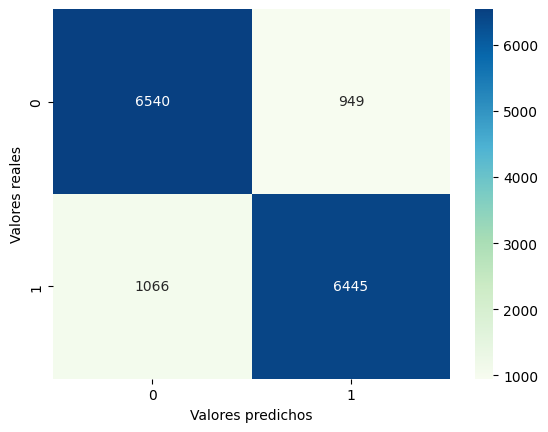

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Realizamos una predicción del dataset de test, realizamos el submit a Kaggle y guardamos el modelo

In [ ]:
y_pred = random_search.predict(ds_test['review_es'])

submission_modelo_stopwords = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred})
submission_modelo_stopwords.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_modelo_stopwords.csv', index=False)

dump(random_search, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_stopwords.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_stopwords.joblib']

### Realizamos otra predicción, esta vez con stemming aplicado

In [ ]:
#Cargo el mejor modelo de naive bayes
modelo = load('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_stopwords.joblib')
#Vuelvo a entrenar el modelo, esta vez con los datos que ya tienen stemming aplicado
modelo.best_estimator_.fit(ds_train_copy['review_es'], ds_train_copy['sentimiento'])

Pipeline(steps=[('hashingvectorizer',
                 HashingVectorizer(alternate_sign=False,
                                   stop_words=['de', 'la', 'que', 'el', 'en',
                                               'y', 'a', 'los', 'del', 'se',
                                               'las', 'por', 'un', 'para',
                                               'con', 'no', 'una', 'su', 'al',
                                               'lo', 'como', 'más', 'pero',
                                               'sus', 'le', 'ya', 'o', 'este',
                                               'sí', 'porque', ...],
                                   strip_accents='ascii')),
                ('multinomialnb', MultinomialNB(alpha=0.30000000000000004))])

In [ ]:
y_pred = modelo.best_estimator_.predict(ds_test['review_es'])

In [ ]:
submission_modelo_stemming = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred})
submission_modelo_stemming.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_modelo_stemming.csv', index=False)

dump(modelo.best_estimator_, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_stemming.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_stemming.joblib']

## RandomForest

Convertimos a numérico los valores de sentimientos binarios

In [ ]:
y_train_bin = y_train.copy()
y_train_bin = y_train_bin.map({'negativo': 0, 'positivo': 1})

Creamos un modelo de RandomForest básico (sin optimizar) en conjunto con TfIdfVectorizer, lo entrenamos y hacemos las predicciones

In [ ]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=99))
model.fit(x_train, y_train_bin)
y_pred = model.predict(x_test)

In [ ]:
y_test_bin = y_test.map({'negativo': 0, 'positivo': 1})
print(classification_report(y_test_bin,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      7489
           1       0.85      0.82      0.83      7511

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'Valores reales')

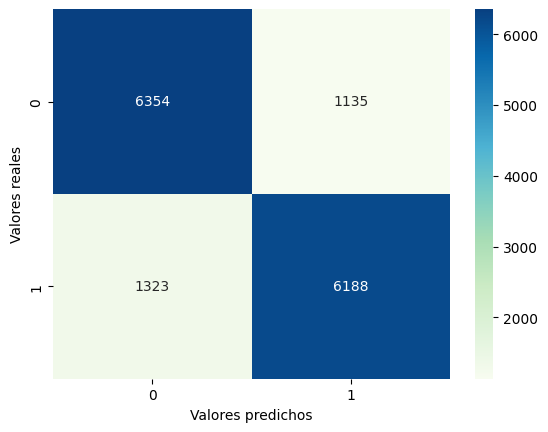

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_bin, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

#### Optimización de hiperparámetros de RandomForest en conjunto de TfIdfVectorizer


Obtenemos los stopwords en español

In [ ]:
import nltk
from nltk.corpus import stopwords

# Descarga la lista de stopwords en español
nltk.download('stopwords')

# Obtiene la lista de stopwords en español
spanish_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Hacemos la búsqueda de mejores hiperparámetros

Mejores hiperparámetros: {'tfidfvectorizer__use_idf': True, 'tfidfvectorizer__sublinear_tf': False, 'tfidfvectorizer__strip_accents': 'unicode', 'tfidfvectorizer__smooth_idf': False, 'tfidfvectorizer__ngram_range': (2, 2), 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__lowercase': False, 'randomforestclassifier__n_estimators': 180, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 70, 'randomforestclassifier__criterion': 'entropy'}
              precision    recall  f1-score   support

    negativo       0.86      0.72      0.78      7489
    positivo       0.76      0.89      0.82      7511

    accuracy                           0.80     15000
   macro avg       0.81      0.80      0.80     15000
weighted avg       0.81      0.80      0.80     15000



Text(50.722222222222214, 0.5, 'Valores reales')

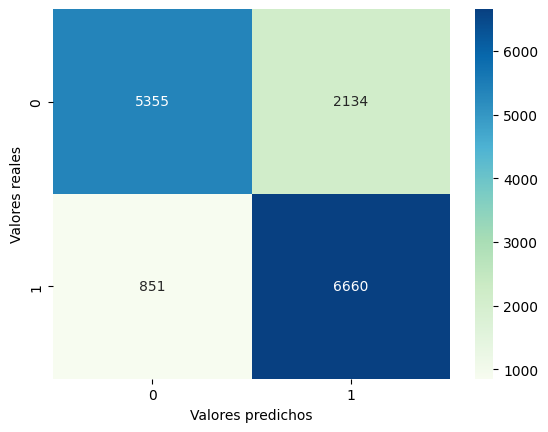

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from nltk.corpus import stopwords

# Crear el modelo de RandomForest con TfidfVectorizer que incluye stopwords en español
model = make_pipeline(
    TfidfVectorizer(stop_words=spanish_stopwords),  # Establece la lista de stopwords en español
    RandomForestClassifier(random_state=99)
)

# Definir el espacio de búsqueda de hiperparámetros para RandomForest
param_dist_rf = {
    'randomforestclassifier__n_estimators': [140, 160, 180, 200],
    'randomforestclassifier__max_depth': [40, 50, 60, 70],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}


# Definir el espacio de búsqueda de hiperparámetros para TfidfVectorizer
param_dist_tfidf = {
    'tfidfvectorizer__strip_accents': [None, 'ascii', 'unicode'],
    'tfidfvectorizer__lowercase': [True, False],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidfvectorizer__max_df': [0.8, 0.9, 1.0],
    'tfidfvectorizer__min_df': [1, 2, 3],
    'tfidfvectorizer__max_features': [1000, 5000, 10000],
    'tfidfvectorizer__use_idf': [True, False],
    'tfidfvectorizer__smooth_idf': [True, False],
    'tfidfvectorizer__sublinear_tf': [True, False]
}
# Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions={**param_dist_tfidf, **param_dist_rf},  # Combinar hiperparámetros
    n_iter=10,
    scoring='f1',
    cv=10,
    random_state=42,
    n_jobs=-1
)

# ENTRENO CON MIS DATOS COMPLETOS ds_train
random_search.fit(ds_train_x, ds_train_y)

# Obtener el mejor modelo y sus hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

#PREDIGO SOBRE MI DATASET COMPLETO DE TEST
y_pred_kaggle_submission = best_model.predict(ds_test) # <--- PARA KAGGLE

# Realizar predicciones en el conjunto de prueba para hacer el classificacion report
y_pred_para_matriz_de_confusion = best_model.predict(x_test)  # <--- PARA LA MATRIZ DE CONFUSION Y EL CLASSIFICATION REPORT

# Calcular el informe de clasificación
print(classification_report(y_test, y_pred_para_matriz_de_confusion))

#Creo la matriz de confusión

tabla=confusion_matrix(y_test, y_pred_para_matriz_de_confusion)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')


Hacemos la prediccion para Kaggle

In [ ]:
y_pred_kaggle_submission = best_model.predict(ds_test['review_es']) # <--- PARA KAGGLE
ds_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [ ]:
y_pred_kaggle_submission

array(['negativo', 'positivo', 'positivo', ..., 'positivo', 'positivo',
       'negativo'], dtype=object)

In [ ]:
ds_train.column

Index(['ID', 'review_es', 'sentimiento'], dtype='object')

In [ ]:
# Creamos el DataFrame con los IDs seleccionados y los valores de y_pred_kaggle_submission
df_submission = pd.DataFrame({'id': ds_test['ID'], 'sentimiento': y_pred_kaggle_submission})

# Verificar la información del DataFrame
df_submission.info()

# Guardar el DataFrame en un archivo CSV
df_submission.to_csv('RandomForestOptimizado_textClassifier_1.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


#### Optimizacion de hiperparámetros de RandomForest en conjunto con CountVectorizer

Comentario: acá no usamos el dataset de entrenamiento con el stemming aplicado

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 6 folds for each of 3 candidates, totalling 18 fits
Mejores hiperparámetros: {'randomforestclassifier__n_estimators': 160, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 70, 'randomforestclassifier__criterion': 'gini', 'countvectorizer__strip_accents': 'unicode', 'countvectorizer__ngram_range': (2, 2), 'countvectorizer__min_df': 1, 'countvectorizer__max_features': 5000, 'countvectorizer__max_df': 0.8, 'countvectorizer__lowercase': False}
              precision    recall  f1-score   support

    negativo       0.95      0.79      0.86      7489
    positivo       0.82      0.96      0.88      7511

    accuracy                           0.88     15000
   macro avg       0.89      0.88      0.87     15000
weighted avg       0.89      0.88      0.87     15000



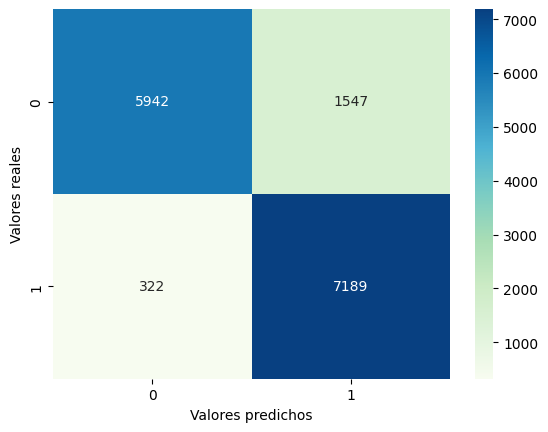

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Descargar la lista de stopwords en español
nltk.download('stopwords')

# Obtener la lista de stopwords en español
spanish_stopwords = stopwords.words('spanish')

# Crear el modelo de RandomForest con CountVectorizer que incluye stopwords en español
model = make_pipeline(
    CountVectorizer(stop_words=spanish_stopwords),  # Establecer la lista de stopwords en español
    RandomForestClassifier(random_state=99)
)

# Definir el espacio de búsqueda de hiperparámetros para RandomForest y CountVectorizer
param_dist = {
    'countvectorizer__strip_accents': [None, 'ascii', 'unicode'],
    'countvectorizer__lowercase': [True, False],
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'countvectorizer__max_df': [0.8, 0.9, 1.0],
    'countvectorizer__min_df': [1, 2, 3],
    'countvectorizer__max_features': [1000, 5000, 10000],
    'randomforestclassifier__n_estimators': [140, 160, 180, 200],
    'randomforestclassifier__max_depth': [40, 50, 60, 70],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

# Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=3,
    scoring='f1',
    cv=6,
    random_state=99,
    n_jobs=-1,
    verbose=4
)

# ENTRENAR CON EL DATASET COMPLETO ds_train (sin stemin)
random_search.fit(ds_train_x, ds_train_y)

# Obtener el mejor modelo y sus hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

# PREDICCIONES EN EL DATASET COMPLETO DE TEST
y_pred_kaggle_submission = best_model.predict(ds_test)  # PARA KAGGLE

# Predicciones en el conjunto de prueba para el classification report y la matriz de confusión
y_pred_para_matriz_de_confusion = best_model.predict(x_test)

# Calcular el informe de clasificación
print(classification_report(y_test, y_pred_para_matriz_de_confusion))

# Crear la matriz de confusión
tabla = confusion_matrix(y_test, y_pred_para_matriz_de_confusion)

# Graficar la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')
plt.show()


In [ ]:
# PREDICCIONES EN EL DATASET COMPLETO DE TEST
y_pred_kaggle_submission = best_model.predict(ds_test['review_es']) # <--- PARA KAGGLE
y_pred_kaggle_submission

array(['negativo', 'positivo', 'positivo', ..., 'positivo', 'negativo',
       'negativo'], dtype=object)

In [ ]:
df_submission = pd.DataFrame({'id': ds_test['ID'], 'sentimiento': y_pred_kaggle_submission})

# Verificar la información del DataFrame
df_submission.info()

# Guardar el DataFrame en un archivo CSV
df_submission.to_csv('RandomForestOptimizado_CountVectorizer.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


### Realizo una nueva predicción con el dataset con stemming aplicado

In [ ]:
best_model_rf = load('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_rf.joblib')

Entrenamos al modelo, que tenía la mejor combinacion de hiperparámetros, con la columna de 'review_es' con el stemming aplicado

In [ ]:
best_model_rf.fit(ds_train_stemmed['review_es'],ds_train_stemmed['sentimiento'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, max_df=0.9, max_features=5000,
                                 min_df=2, ngram_range=(2, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 strip_accents='unicode')),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=70,
                                        max_features='log2', min_samples_leaf=4,
                                        min_samples_split=5, n_estimators=180,
                                        random_state=99))])

Hacemos la prediccion sobre nuestro dataset de test

In [ ]:
y_pred = best_model_rf.predict(ds_test['review_es'])

Creamos la tabla para submitear en kaggle

In [ ]:
df_submission = pd.DataFrame({'id': ds_test['ID'], 'sentimiento': y_pred})

# Verificar la información del DataFrame
df_submission.info()

# Guardar el DataFrame en un archivo CSV
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/RandomForestOptimizado_stemming.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


## XGBoost

In [ ]:
y_train_bin = y_train.copy()

Hacemos la transformacion de los valores binarios de las etiquetas (en el dataset de train) de string a numérico

In [ ]:
y_train_bin = y_train_bin.map({'negativo': 0, 'positivo': 1})

Obtenemos los stopwords en español, creamos instancias básicas de TfIdfVectorizer y XGBoost y predecimos sobre nuestro dataset de test

In [ ]:
stopwords = nltk.corpus.stopwords.words('spanish')

model = make_pipeline(TfidfVectorizer(stop_words = stopwords), XGBClassifier(objective='binary:logistic', random_state=99))
model.fit(x_train, y_train_bin)
y_pred = model.predict(x_test)

In [ ]:
#Hacemos la conversion de para poder comparar la prediccion
y_test_bin = y_test.map({'negativo': 0, 'positivo': 1})
print(classification_report(y_test_bin,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7489
           1       0.83      0.87      0.85      7511

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'Valores reales')

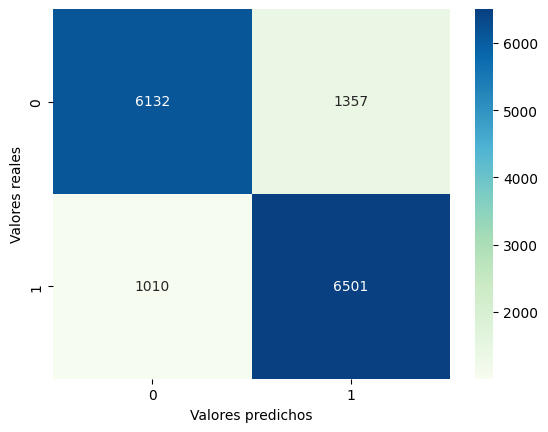

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_bin, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

#### Optimización de hiperparámetros de XGBoost en conjunto con TfIdfVectorizer


In [ ]:
ds_train_y_bin = ds_train['sentimiento'].map({'negativo': 0, 'positivo': 1})

In [ ]:
# Obtiene la lista de stopwords en español
stopwords = nltk.corpus.stopwords.words('spanish')

model = make_pipeline(
    TfidfVectorizer(stop_words = stopwords),  # Establece la lista de stopwords en español
    xgb.XGBClassifier(objective='binary:logistic', random_state=99)
)

# Defino la grilla de hiperparámetros y sus rangos
param_dist = {
    'xgbclassifier__learning_rate': uniform(0, 1),
    'xgbclassifier__max_depth': randint(3, 10),
    #'xgbclassifier__subsample': uniform(0.5, 0.5),
    #'xgbclassifier__colsample_bytree': uniform(0.5, 0.5),
    'xgbclassifier__gamma': uniform(0, 1),
    'xgbclassifier__alpha': uniform(0, 1),
    'xgbclassifier__lambda': uniform(0, 1),
    'xgbclassifier__n_estimators': randint(50, 200),

    'tfidfvectorizer__strip_accents': [None, 'ascii'],
    'tfidfvectorizer__lowercase': [True, False],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidfvectorizer__max_df': [0.8, 0.9, 1.0],
    'tfidfvectorizer__min_df': [1, 2, 3],
    'tfidfvectorizer__max_features': [1000, 5000, 10000],
    'tfidfvectorizer__use_idf': [True, False],
    'tfidfvectorizer__smooth_idf': [True, False],
    'tfidfvectorizer__sublinear_tf': [True, False]
}

# Busca el mejor modelo de XGBoost con RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions= param_dist,
    n_iter=4, ## <--- Prueba 4 combinaciones aleatorias.
    scoring='f1',
    cv=10, ## <-- Prueba con 10 splits para el cross validation
    random_state=99,
    verbose = 4
)

# ENTRENO CON MIS DATOS COMPLETOS ds_train
random_search.fit(ds_train_x, ds_train_y_bin) # <-- IMPORTANTISIMO QUE SE ENTRENE CON LOS DATASET COMPLETOS, Y NO CON EL 70% - 30%

# Obtener el mejor modelo y sus hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_params

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END tfidfvectorizer__lowercase=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__max_features=1000, tfidfvectorizer__min_df=2, tfidfvectorizer__ngram_range=(1, 1), tfidfvectorizer__smooth_idf=True, tfidfvectorizer__strip_accents=None, tfidfvectorizer__sublinear_tf=False, tfidfvectorizer__use_idf=True, xgbclassifier__alpha=0.5656174196105306, xgbclassifier__gamma=0.29762249870394397, xgbclassifier__lambda=0.04669572050695325, xgbclassifier__learning_rate=0.9906273994707961, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=109;, score=0.790 total time= 1.3min
[CV 2/10] END tfidfvectorizer__lowercase=False, tfidfvectorizer__max_df=0.9, tfidfvectorizer__max_features=1000, tfidfvectorizer__min_df=2, tfidfvectorizer__ngram_range=(1, 1), tfidfvectorizer__smooth_idf=True, tfidfvectorizer__strip_accents=None, tfidfvectorizer__sublinear_tf=False, tfidfvectorizer__use_idf=True, xgbclassifier__alpha=0.5656174196105306

{'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 0.8,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': True,
 'tfidfvectorizer__use_idf': False,
 'xgbclassifier__alpha': 0.36050726453927373,
 'xgbclassifier__gamma': 0.33167662117194163,
 'xgbclassifier__lambda': 0.6274314008177302,
 'xgbclassifier__learning_rate': 0.6934763924278945,
 'xgbclassifier__max_depth': 9,
 'xgbclassifier__n_estimators': 112}

**Mejores hiperparámetros:**

{'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 0.8,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': True,
 'tfidfvectorizer__use_idf': False,
 'xgbclassifier__alpha': 0.36050726453927373,
 'xgbclassifier__gamma': 0.33167662117194163,
 'xgbclassifier__lambda': 0.6274314008177302,
 'xgbclassifier__learning_rate': 0.6934763924278945,
 'xgbclassifier__max_depth': 9,
 'xgbclassifier__n_estimators': 112}

In [ ]:
random_search.best_score_

0.8383574451311352

Hacemos la prediccion para kaggle y para la matriz de confusion

In [ ]:
#PREDIGO SOBRE MI DATASET COMPLETO DE TEST
y_pred_kaggle_submission = best_model.predict(ds_test['review_es']) # <--- PARA KAGGLE

# Realizar predicciones en el conjunto de prueba para hacer el classificacion report

y_pred_para_matriz_de_confusion = best_model.predict(x_test)  # <--- PARA LA MATRIZ DE CONFUSION Y EL CLASSIFICATION REPORT

# Calcular el informe de clasificación
print(classification_report(y_test_bin, y_pred_para_matriz_de_confusion))

#Creo la matriz de confusión

tabla=confusion_matrix(y_test_bin, y_pred_para_matriz_de_confusion)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')


Creamos la tabla para submitear a Kaggle

In [ ]:
#Guardamos el modelo
dump(best_model, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_xgbboost.joblib')

#Generamos csv para Kaggle
submission_opt_xgb = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred_submission})
submission_opt_xgb.sentimiento = submission_opt_xgb.sentimiento.map({0: 'negativo', 1: 'positivo'})
submission_opt_xgb.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_opt_xgb.csv', index=False)

### Realizo una nueva predicción con el dataset con stemming aplicado

In [ ]:
best_model_xgb = load('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_xgbboost.joblib')

In [ ]:
best_model_xgb.best_estimator_.fit(ds_train_stemmed['review_es'],ds_train_y_bin)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, max_features=10000,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 sublinear_tf=True, use_idf=False)),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.36050726453...
                               feature_types=None, gamma=0.33167662117194163,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=0.6274314008177302,
                               learning_rate=0.6934763924278945, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=112,
                               n_jobs=None, ...))])

In [ ]:
y_pred = best_model_xgb.predict(ds_test['review_es'])

In [ ]:
df_submission = pd.DataFrame({'id': ds_test['ID'], 'sentimiento': y_pred})
df_submission.sentimiento = df_submission.sentimiento.map({0: 'negativo', 1: 'positivo'})
# Verificar la información del DataFrame
df_submission.info()

# Guardar el DataFrame en un archivo CSV
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/modelo_optimizado_stemming_xgboost.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [ ]:
df_submission.head()

,id,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,positivo
3,60003,negativo
4,60004,positivo


## Red neuronal

### Hacemos una red neuronal básica con embedding en español

In [ ]:
ds_train_preprocesado = ds_train_copy.copy()
ds_train_preprocesado.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/datasets/train_con_stemming_aplicado.csv')

In [ ]:
ds_test_preprocesado = ds_test.copy()
ds_test_preprocesado['review_es'] = ds_test_preprocesado['review_es'].apply(apply_stemming)
ds_test_preprocesado.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/datasets/test_con_stemming_aplicado.csv')

In [ ]:
y_train_bin = y_train.copy()
y_train_bin = y_train_bin.map({'negativo': 0, 'positivo': 1})

y_test_bin = y_test.copy()
y_test_bin = y_test_bin.map({'negativo': 0, 'positivo': 1})

ds_train_y_bin = ds_train_y.copy()
ds_train_y_bin = ds_train_y_bin.map({'negativo': 0, 'positivo': 1})

In [ ]:
!pip install tensorflow-hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.14.0
Eager mode:  True
Hub version:  0.15.0
GPU is NOT AVAILABLE


In [ ]:
# Crear un conjunto de datos de TensorFlow para entrenamiento
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin))

# Crear un conjunto de datos de TensorFlow para prueba
validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin))

# Creamos un conjunto de datos de TensorFlow para entrenamiento con todo el dataset entero preprocesado (con el stemming aplicado)
full_train_data = tf.data.Dataset.from_tensor_slices((ds_train_preprocesado['review_es'], ds_train_y_bin))

test_data = tf.data.Dataset.from_tensor_slices((ds_test['review_es']))


In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

In [ ]:
#Utilizamos un embedding en español
embedding = "https://tfhub.dev/google/nnlm-es-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 1.2568082 , -0.4240418 , -0.21261834, -0.15864907,  0.14218198,
         0.26415667, -0.21938267,  0.16808572, -0.57886875,  0.54842854,
        -0.02695455, -0.014637  , -0.44808292, -0.34956774,  0.13642496,
         0.3790391 ,  0.38785222,  0.02965165, -0.37425184, -0.4263551 ,
        -0.59753644,  0.13993509, -0.41892475,  0.07894509, -0.05860753,
         0.23630966,  0.06260155,  0.10531923, -0.24561104, -0.01204985,
        -0.20267922,  0.6783359 , -0.22916022,  0.08402988,  0.03307225,
         0.31427926,  0.7365846 , -0.32710096, -0.01465473, -0.34436512,
        -0.32286692,  0.11268483,  0.15004244,  0.90087885,  0.15750422,
         0.19152626,  0.04074623, -0.40033767,  0.1008134 , -0.5249805 ],
       [-1.306359  ,  0.06654456,  1.9976982 ,  1.6909673 , -5.6752477 ,
         3.0576103 , -1.5797827 , -0.9561491 , -0.6608932 , -0.13015573,
        -0.7895992 , -0.87349206, -2.1181371 , -0.9714413 , -2.3927119 ,
 

Creamos una red neuronal básica

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48832000  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48832833 (186.28 MB)
Trainable params: 48832833 (186.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Entrenamos el modelo de red neuronal básica

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
69/69 [==============================] - 63s 910ms/step - loss: 0.6188 - accuracy: 0.5933 - val_loss: 0.5120 - val_accuracy: 0.7214
Epoch 2/10
69/69 [==============================] - 70s 1s/step - loss: 0.4057 - accuracy: 0.8125 - val_loss: 0.3651 - val_accuracy: 0.8267
Epoch 3/10
69/69 [==============================] - 59s 860ms/step - loss: 0.2668 - accuracy: 0.8891 - val_loss: 0.3194 - val_accuracy: 0.8569
Epoch 4/10
69/69 [==============================] - 59s 856ms/step - loss: 0.1840 - accuracy: 0.9308 - val_loss: 0.3159 - val_accuracy: 0.8569
Epoch 5/10
69/69 [==============================] - 58s 832ms/step - loss: 0.1273 - accuracy: 0.9562 - val_loss: 0.3272 - val_accuracy: 0.8638
Epoch 6/10
69/69 [==============================] - 60s 862ms/step - loss: 0.0869 - accuracy: 0.9747 - val_loss: 0.3519 - val_accuracy: 0.8636
Epoch 7/10
69/69 [==============================] - 59s 855ms/step - loss: 0.0587 - accuracy: 0.9867 - val_loss: 0.3794 - val_accuracy: 0.8574
Ep

In [ ]:
dump(model, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_tf.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_tf.joblib']

Predecimos con el dataset entero de test

In [ ]:
y_pred = model.predict(ds_test['review_es'], verbose = 2)

269/269 - 26s - 26s/epoch - 97ms/step


In [ ]:
y_pred

array([[-6.6793013],
       [-1.0680817],
       [ 1.3264925],
       ...,
       [ 2.5445523],
       [-3.4945495],
       [ 5.683993 ]], dtype=float32)

Al ser y_pred valores continuos, vamos a mapear cada valor según el critero siguiente

In [ ]:
y_pred_final = list(map(lambda x: 'positivo' if x > 0 else 'negativo', y_pred))

In [ ]:
submission_red_neuronal = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred_final})
submission_red_neuronal.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_red_neuronal.csv', index=False)

---

Chequeamos que se formó una tabla

In [ ]:
submission_red_neuronal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


---

### Prueba con un embedding normalizado

Hacemos las transformaciones sobre las etiquetas de train y test

In [ ]:
y_train_bin = y_train.copy()
y_train_bin = y_train_bin.map({'negativo': 0, 'positivo': 1})

y_test_bin = y_test.copy()
y_test_bin = y_test_bin.map({'negativo': 0, 'positivo': 1})

ds_train_y_bin = ds_train_y.copy()
ds_train_y_bin = ds_train_y_bin.map({'negativo': 0, 'positivo': 1})

In [ ]:
!pip install tensorflow-hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Crear un conjunto de datos de TensorFlow para entrenamiento
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin))

# Crear un conjunto de datos de TensorFlow para prueba
validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin))

# Creamos un conjunto de datos de TensorFlow para entrenamiento con todo el dataset entero preprocesado (con el stemming aplicado)
full_train_data = tf.data.Dataset.from_tensor_slices((ds_train_preprocesado['review_es'], ds_train_y_bin))

test_data = tf.data.Dataset.from_tensor_slices((ds_test['review_es']))


In [ ]:
#Utilizamos un embedding en español normalizado

embedding = hub.load("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/es-dim128-with-normalization/versions/1")
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 1.31634426e+00, -5.53583026e-01,  2.11157069e-01,
         1.62603930e-01, -1.74071565e-01, -2.79143453e-01,
        -3.40094656e-01, -5.27133867e-02, -1.54268637e-01,
         1.94167316e-01,  2.00214386e-01,  9.52787250e-02,
        -3.50401253e-02, -9.64035392e-02,  9.93275344e-02,
         4.20730524e-02, -3.65623206e-01,  5.74279651e-02,
         4.95432056e-02,  3.48737873e-02, -6.69720843e-02,
         1.36971578e-01, -7.98485950e-02, -2.48903215e-01,
        -8.01070333e-02,  5.63085936e-02, -3.52147579e-01,
        -1.02620065e-01,  1.25542223e-01,  1.45001963e-01,
        -1.84660792e-01,  5.51218586e-03,  1.60286069e-01,
        -1.89066455e-01,  2.20353872e-01,  7.05523640e-02,
        -1.94801018e-01, -2.92388171e-01,  3.60099822e-02,
        -7.17677847e-02, -1.08152039e-01,  2.61824369e-01,
         4.60888386e-01,  2.90713847e-01,  3.86475265e-01,
         1.23286247e-01,  4.15770471e-01, -1.57791257e-01,
      

Creamos de nuevo una red neuronal básica

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               125009920 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125014081 (476.89 MB)
Trainable params: 125014081 (476.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Entrenamos el modelo de red neuronal pero esta vez con su capa de embedding normalizado

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=16,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/16
69/69 [==============================] - 256s 4s/step - loss: 0.5789 - accuracy: 0.6210 - val_loss: 0.4225 - val_accuracy: 0.7965
Epoch 2/16
69/69 [==============================] - 244s 4s/step - loss: 0.3153 - accuracy: 0.8693 - val_loss: 0.2876 - val_accuracy: 0.8749
Epoch 3/16
69/69 [==============================] - 268s 4s/step - loss: 0.1930 - accuracy: 0.9292 - val_loss: 0.2574 - val_accuracy: 0.8899
Epoch 4/16
69/69 [==============================] - 243s 4s/step - loss: 0.1243 - accuracy: 0.9610 - val_loss: 0.2563 - val_accuracy: 0.8908
Epoch 5/16
69/69 [==============================] - 254s 4s/step - loss: 0.0790 - accuracy: 0.9793 - val_loss: 0.2696 - val_accuracy: 0.8926
Epoch 6/16
69/69 [==============================] - 244s 4s/step - loss: 0.0487 - accuracy: 0.9905 - val_loss: 0.2855 - val_accuracy: 0.8901
Epoch 7/16
69/69 [==============================] - 249s 4s/step - loss: 0.0304 - accuracy: 0.9957 - val_loss: 0.3064 - val_accuracy: 0.8877
Epoch 8/16
69

Predecimos sobre el dataset entero de test (para la predicción de Kaggle)

In [ ]:
y_pred = model.predict(ds_test['review_es'], verbose = 2)

269/269 - 1s - 673ms/epoch - 3ms/step


In [ ]:
y_pred

array([[ 4.9871874],
       [-8.577467 ],
       [ 1.1031841],
       ...,
       [-2.7746353],
       [-6.4678864],
       [-5.541673 ]], dtype=float32)

Hacemos la transformacion de nuevo para la exportación de la tabla a Kaggle

In [ ]:
y_pred = list(map(lambda x: 'positivo' if x > 0 else 'negativo', y_pred))

In [ ]:
submission_red_neuronal2 = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred})
submission_red_neuronal2.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_red_neuronal4.csv', index=False)

In [ ]:
#Guardamos el modelo
tf.saved_model.save(embedding, "embedding_espanol_normalizado")
model.save('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_red_neuronal3')

---

In [ ]:
submission_red_neuronal2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


### <h1> Optimizacion de hiperparámetros de una arquitectura de red neuronal </h1>

#### Definimos la arquitectura

In [ ]:
import keras
from keras.layers import Dropout
from keras.regularizers import l2

# Defino la capa con el embedding normalizado
embedding = hub.load("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/es-dim128-with-normalization/versions/1")
embedding_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

'''
-Tiene 3 hiperparámetros para optimizar: cant neuronas, cant capas ocultas, valor del learning_rate
-Utiliza el optimizador SGD con un learning_rate paramétrico
-Utiliza el regulador L2 en la capa de entrada con un valor constante de learning_rate = 0.01
-Utiliza el regulador Dropout en las capas ocultas
-Utiliza el regulador L2 para la capa de salida,  con un learning_rate = 0.01
-Tiene una capa de embedding normalizado
'''
def create_model_3(hidden_layers=1, neurons=128, ln_rate_parameter=0.01):
    # Optimizador SGD con learning rate variable
    optimizer = keras.optimizers.SGD(learning_rate=ln_rate_parameter)
    model = keras.Sequential()
    # Capa de Embedding
    model.add(embedding_layer)
    model.add(keras.layers.Dense(neurons, activation='relu', kernel_regularizer=l2(0.01)))

    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))  # Añado técnica de regularización por capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Creamos tensores

In [ ]:
# Crear un conjunto de datos de TensorFlow para entrenamiento
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin))
# Crear un conjunto de datos de TensorFlow para prueba
validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin))
full_train_data = tf.data.Dataset.from_tensor_slices((ds_train_x, ds_train_y_bin))
test_data = tf.data.Dataset.from_tensor_slices((ds_test['review_es']))

#### Hacemos una búsqueda de mejores hiperparámetros de la arquitectura

In [ ]:
from sklearn.metrics import f1_score
import keras
from keras.layers import Dropout
from keras.regularizers import l2

# Defino la capa con el embedding normalizado
embedding = hub.load("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/es-dim128-with-normalization/versions/1")
embedding_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

def create_model_3(hidden_layers=1, neurons=128, ln_rate_parameter=0.01):
    # Optimizador SGD con learning rate variable
    optimizer = keras.optimizers.SGD(learning_rate=ln_rate_parameter)
    model = keras.Sequential()
    # Capa de Embedding
    model.add(embedding_layer)
    model.add(keras.layers.Dense(neurons, activation='relu', kernel_regularizer=l2(0.01)))

    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))  # Añado técnica de regularización por capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=1,
    min_delta=0.1  # Ajusta este valor según tus necesidades
)

model = KerasClassifier(build_fn=create_model_3,callbacks=[early_stopping])

param_dist_architecture = {
    'neurons': [16, 32, 64, 128],
    'hidden_layers': [1, 2, 3],
    # 'ln_rate_parameter': [0.001, 0.005, 0.0001, 0.01]
    'ln_rate_parameter': [0.3, 0.4, 0.01, 0.001]
}

# Obtenemos los tensores de dimension 1 que necesita la capa de Embedding para funcionar correctamente
X_train = np.array([x.numpy() for x, _ in full_train_data])
y_train = np.array([y.numpy() for _, y in full_train_data])

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=3,
                                                cv=3,
                                                scoring='f1',
                                                verbose=99,
                                               )

# Optimizamos hiperparámetros de arquitectura
random_search_architecture.fit(X_train,y_train)

# Obtener la mejor arquitectura encontrada
best_architecture = random_search_architecture.best_estimator_.model
best_params = random_search_architecture.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START hidden_layers=2, ln_rate_parameter=0.001, neurons=16........
521/521 [==============================] - 225s 431ms/step
[CV 1/3; 1/3] END hidden_layers=2, ln_rate_parameter=0.001, neurons=16;, score=0.534 total time=12.8min
[CV 2/3; 1/3] START hidden_layers=2, ln_rate_parameter=0.001, neurons=16........
521/521 [==============================] - 217s 416ms/step
[CV 2/3; 1/3] END hidden_layers=2, ln_rate_parameter=0.001, neurons=16;, score=0.604 total time=12.0min
[CV 3/3; 1/3] START hidden_layers=2, ln_rate_parameter=0.001, neurons=16........
521/521 [==============================] - 225s 431ms/step
[CV 3/3; 1/3] END hidden_layers=2, ln_rate_parameter=0.001, neurons=16;, score=0.469 total time=12.2min
[CV 1/3; 2/3] START hidden_layers=2, ln_rate_parameter=0.01, neurons=64.........
521/521 [==============================] - 225s 432ms/step
[CV 1/3; 2/3] END hidden_layers=2, ln_rate_parameter=0.01, neurons=64

NameError: ignored

El error del log anterior se debe a que al final nos habíamos equivocado de nombre de variable, pero como tardó bastante tiempo imprimir todo eso, dejamos esa expresion de error.

Ahora obtenemos los mejores hiperparámetros de la red neuronal:

In [ ]:
best_params = random_search_architecture.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'neurons': 128, 'ln_rate_parameter': 0.01, 'hidden_layers': 1}


#### Hacemos una búsqueda de mejores hiperparámetros de entrenamiento para la mejor red neuronal encontrada

In [ ]:
# Creamos un modelo de red neuronal con los mejores valores de los hiperparámetros
best_model = best_architecture

# Optimizamos epochs y batch_size
param_dist_training = {
    'epochs': [10, 20, 30],
    'batch_size': [128, 256, 512]
}


#Hacemos la búsqueda de mejores valores de hiperparámetros para el entrenamiento
random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model),
                                            param_distributions=param_dist_training,
                                            n_iter=3,
                                            verbose=99,
                                            cv=3) # <-- es un detallecito que se puede borrar

random_search_training.fit(X_train, y_train)

# Obtenemos los mejores hiperparámetros
best_training = random_search_training.best_params_

# Entrenamos el mejor modelo obtenido anteriormente, ahora con los mejores hiperparámetros de entrenamiento
best_model.fit(train_data, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START batch_size=256, epochs=20...................................
Epoch 1/20
131/131 [==============================] - 61s 464ms/step - loss: 1.2644 - accuracy: 0.7434
Epoch 2/20
131/131 [==============================] - 57s 435ms/step - loss: 1.2262 - accuracy: 0.7454
Epoch 3/20
131/131 [==============================] - 58s 440ms/step - loss: 1.1902 - accuracy: 0.7475
Epoch 4/20
131/131 [==============================] - 59s 448ms/step - loss: 1.1562 - accuracy: 0.7509
Epoch 5/20
131/131 [==============================] - 57s 438ms/step - loss: 1.1239 - accuracy: 0.7531
Epoch 6/20
131/131 [==============================] - 57s 435ms/step - loss: 1.0934 - accuracy: 0.7547
Epoch 7/20
131/131 [==============================] - 56s 431ms/step - loss: 1.0644 - accuracy: 0.7574
Epoch 8/20
131/131 [==============================] - 62s 473ms/step - loss: 1.0371 - accuracy: 0.7612
Epoch 9/20
131/131 [================

NameError: ignored

Nos falló el entrenamiento del mejor modelo porque nos equivocamos de nombre de variable, pero como tarda bastante esto, decidimos dejarlo en el log el error, y ahora en lo siguiente entrenar al mejor modelo con los mejores hiperparámetros de la red neuronal y de entrenamiento

<h1> Obtenemos los mejores hiperparámetros del entrenamiento de la mejor red neuronal dado el RandomizedSearchCV </h1>

In [ ]:
best_training = random_search_training.best_params_
best_training

{'epochs': 30, 'batch_size': 512}

Entrenamos ahora al mejor modelo de red neuronal encontrado con los mejores hiperparámetros de entrenamiento:

In [ ]:
# Entrenamos el mejor modelo obtenido anteriormente, ahora con los mejores hiperparámetros de entrenamiento
best_model.fit(X_train,y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

Epoch 1/30
98/98 [==============================] - 61s 616ms/step - loss: 0.4437 - accuracy: 0.8635
Epoch 2/30
98/98 [==============================] - 65s 665ms/step - loss: 0.4435 - accuracy: 0.8632
Epoch 3/30
98/98 [==============================] - 43s 440ms/step - loss: 0.4434 - accuracy: 0.8636
Epoch 4/30
98/98 [==============================] - 45s 462ms/step - loss: 0.4432 - accuracy: 0.8635
Epoch 5/30
98/98 [==============================] - 44s 453ms/step - loss: 0.4431 - accuracy: 0.8635
Epoch 6/30
98/98 [==============================] - 46s 466ms/step - loss: 0.4429 - accuracy: 0.8639
Epoch 7/30
98/98 [==============================] - 43s 437ms/step - loss: 0.4427 - accuracy: 0.8641
Epoch 8/30
98/98 [==============================] - 45s 464ms/step - loss: 0.4426 - accuracy: 0.8638
Epoch 9/30
98/98 [==============================] - 43s 444ms/step - loss: 0.4424 - accuracy: 0.8639
Epoch 10/30
98/98 [==============================] - 43s 441ms/step - loss: 0.4423 - accura

#### <h1> Exportamos el mejor modelo entrenado</h1>

In [ ]:
dump(best_model, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_red_neuronal_borrador_optimizado_con_regularizadores.joblib')

#### <h1> Hacemos la exportación a kaggle </h1>

In [ ]:
# Acá obtengo predicciones continuas
y_pred = best_model.predict(ds_test['review_es'], verbose=99)

# Aplicar un umbral (por ejemplo, 0.5) para convertir a etiquetas binarias ("positivo" ó "negativo")
umbral = 0.5
y_pred_final = list(map(lambda x: 'positivo' if x > umbral else 'negativo', y_pred))

# Crear la tabla con las predicciones
submission_red_neuronal = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': y_pred_final})

# Guardar la tabla en un archivo CSV
submission_red_neuronal.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_red_neuronal_con_regularizadores.csv', index=False)

#### Armamos la matriz de confusión

In [ ]:
y_pred

array([[0.7624933 ],
       [0.388216  ],
       [0.95279986],
       ...,
       [0.46422684],
       [0.83188003],
       [0.91002   ]], dtype=float32)

In [ ]:
y_test_bin

8800     1
24061    0
1144     1
2703     0
5542     0
        ..
29555    1
44184    1
47703    1
42297    1
48148    1
Name: sentimiento, Length: 15000, dtype: int64

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7489
           1       0.87      0.87      0.87      7511

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



Text(50.722222222222214, 0.5, 'Valores reales')

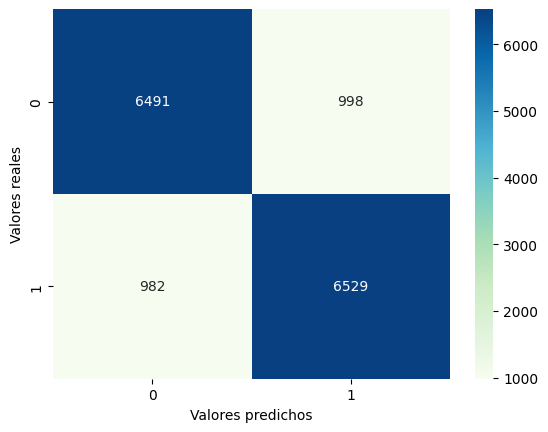

In [ ]:
# Aplicar un umbral (por ejemplo, 0.5) para convertir a etiquetas binarias ("positivo" ó "negativo")
umbral = 0.5
y_pred_final = list(map(lambda x: 1 if x > umbral else 0, y_pred))

print(classification_report(y_test_bin,y_pred_final))
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_bin, y_pred_final)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

## Ensamble

Vamos a crear un ensamble híbrido de tipo Voting, cuyos modelos a utilizar serán los mejores modelos de RandomForest, XGBoost y Naive Bayes.



In [ ]:
best_xgb_model = load('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_xgbboost.joblib').best_estimator_

spanish_stopwords = stopwords.words('spanish')
best_random_forest_model = make_pipeline(
    TfidfVectorizer(stop_words=spanish_stopwords,use_idf=True, sublinear_tf = False, strip_accents='unicode', ngram_range=(2,2), min_df=2, max_features=5000, max_df=0.9, lowercase=False),
    RandomForestClassifier(random_state=99, n_estimators=180, min_samples_split=5, min_samples_leaf=4, max_features='log2', max_depth=70, criterion='entropy')
)

dump(best_random_forest_model, '/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_rf.joblib')

best_bayes_model = load('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/modelo_optimizado_hashvectorizer.joblib').best_estimator_

In [ ]:
#Creo ensamble de Votación
vot_clf = VotingClassifier(estimators = [('rnd', best_random_forest_model), ('bayes',best_bayes_model),('xgb',best_xgb_model)], voting = 'hard')

              precision    recall  f1-score   support

    negativo       0.88      0.85      0.87      7489
    positivo       0.86      0.89      0.87      7511

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



Text(50.722222222222214, 0.5, 'True')

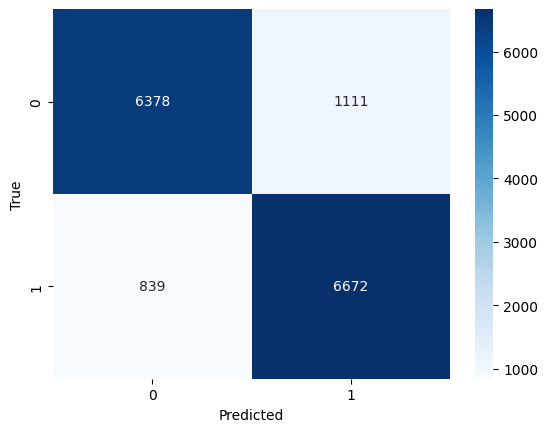

In [ ]:
#Entreno el ensamble con los datasets enteros
vot_clf.fit(ds_train_copy['review_es'], ds_train_copy['sentimiento'])

#Evaluo en conjunto de test con x_test, para poder armar la matriz de correlación.
y_pred = vot_clf.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Genero predicción del dataset test con fit completo de train para Kaggle:

In [ ]:
vot_clf.fit(ds_train_copy['review_es'], ds_train_copy['sentimiento'])
y_pred_kaggle_submission = vot_clf.predict(ds_test['review_es'])

df_submission_voting = pd.DataFrame({'id': ds_test['ID'], 'sentimiento': y_pred_kaggle_submission})
df_submission_voting.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/submissions/submission_ensamble_voting_con_stemming.csv', index=False)
# Verificar la información del DataFrame
df_submission_voting.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8599 non-null   int64 
 1   sentimiento  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Guardo el ensamble

In [ ]:
dump(vot_clf,'/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/ensamble_voting_con_Stemming.joblib')

['/content/drive/MyDrive/Tp_Datos_2023_2°/TP2/modelos/ensamble_voting_con_Stemming.joblib']